In [77]:
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from lbl2vec import Lbl2Vec
from gensim.downloader import load
import numpy as np

# Plan Overview:
0. Keyword Definition
1. Data Preparation
2. Model Training

### 0. Keyword Definition

#### Categories:

    1.  Bike Lane Obstruction: bike, cycle, path,  
    2.  Bus Lane Obstruction: bus, stop, 
    3.  Non-resident Parking: resident, state
    4.  Blocked Fire Hydrant: fire, hydrant
    5.  Blocked Sidewalk: sidewalk, side, walk
    6.  Blocked Driveway: driveway, drive, way, private
    7.  Blocked Crosswalk: crosswalk, cross, walk
    8.  Blocked Handicap spot: handicap, placard,
    9.  Double Parking: double, triple
    10. No stopping zone: stopping, zone
    11. visitor spot: visitor, hour

In [78]:
category_keywords_dict = {
    'bike lane' :           ['bike', 'cycle', 'cycling', 'path', 'sharrow'],
    'bus lane' :            ['bus'],
    'resident parking' :    ['resident', 'state', 'plate', 'plates'],
    'fire hydrant' :        ['fire', 'hydrant'],
    'sidewalk' :            ['sidewalk', 'side'],
    'driveway' :            ['driveway', 'drive', 'way', 'private'],
    'crosswalk' :           ['crosswalk', 'cross'],
    'handicap' :            ['handicap', 'placard'],
    'double parking' :      ['double', 'triple'],
    'no stopping' :         ['stopping', 'loading'],
    'visitor parking' :     ['visitor', 'hour']
} 

category_keywords = pd.DataFrame(data=category_keywords_dict.items(), columns=['category', 'keywords'])
category_keywords

,category,keywords
0,bike lane,"[bike, cycle, cycling, path, sharrow]"
1,bus lane,[bus]
2,resident parking,"[resident, state, plate, plates]"
3,fire hydrant,"[fire, hydrant]"
4,sidewalk,"[sidewalk, side]"
5,driveway,"[driveway, drive, way, private]"
6,crosswalk,"[crosswalk, cross]"
7,handicap,"[handicap, placard]"
8,double parking,"[double, triple]"
9,no stopping,"[stopping, loading]"


### 1. Data Preparation (Add Lemmatization)

In [79]:
# Load pickled service descriptions
with open('pre-processing/API-responses/service_req_desc_03-02-24_01_09_24.pkl', 'rb') as file:
    service_id_to_descriptions:dict = pickle.load(file)

# Remove special characters and downcase, then tokenize
def tokenize(doc):
    return simple_preprocess(doc, deacc=True, min_len=2, max_len=15)

service_drescriptions_df = pd.DataFrame(data=service_id_to_descriptions.items(), columns=['ID', 'Description'])
service_drescriptions_df.head()

,ID,Description
0,101005335950,Illegal parking in the commercial loading Zone...
1,101005335949,Red Honda w New York plates illegally parked o...
2,101005335934,Car completely blocking turn in fire lane
3,101005335925,Double parking alone mass ave. No enforcement....
4,101005335924,truck on sidewalk


#### Test, Training, Validate Split

In [80]:
# Train=.70, Validate=.15, Test=.15
# Split all data between train, (test AND validate)
desc_train, desc_testval = train_test_split(service_drescriptions_df, test_size=.3)

# Split (test AND validate) between test, validate
# .3 * .5 = 0.15
desc_val, desc_test = train_test_split(desc_testval, test_size=0.5)

In [81]:
desc_train['data_type'] = 'train'
desc_test['data_type'] = 'test'
desc_val['data_type'] = 'validate'

all_descriptions = pd.concat([desc_train, desc_test, desc_val]).reset_index(drop=True)
all_descriptions.head()

,ID,Description,data_type
0,101005277072,Two cars parking in no parking zone at curb cu...,train
1,101005248178,Multiple cars parked illegally in resident per...,train
2,101005266371,Again same New Hampshire car parked in a fire ...,train
3,101005248669,A dark gray Honda Accord had been double parke...,train
4,101005325123,-- auto translated (en) -- THE SAME CAR HAS BE...,train


#### Service ID to Tag function

In [82]:
service_id_list = []
def service_id_to_tag(service_id:int) -> int:
    if service_id in service_id_list:
        return service_id_list.index(service_id)
    service_id_list.append(service_id)
    return len(service_id_list)

#### Tagging Descriptions

In [83]:
all_descriptions['tagged_desc'] = all_descriptions.apply(lambda row: TaggedDocument(tokenize(row['Description']), [service_id_to_tag(int(row['ID']))]), axis=1)
all_descriptions.head()

,ID,Description,data_type,tagged_desc
0,101005277072,Two cars parking in no parking zone at curb cu...,train,"([two, cars, parking, in, no, parking, zone, a..."
1,101005248178,Multiple cars parked illegally in resident per...,train,"([multiple, cars, parked, illegally, in, resid..."
2,101005266371,Again same New Hampshire car parked in a fire ...,train,"([again, same, new, hampshire, car, parked, in..."
3,101005248669,A dark gray Honda Accord had been double parke...,train,"([dark, gray, honda, accord, had, been, double..."
4,101005325123,-- auto translated (en) -- THE SAME CAR HAS BE...,train,"([auto, translated, en, the, same, car, has, b..."


### 2. Model Training

In [84]:
model = Lbl2Vec(
    keywords_list=list(category_keywords['keywords']),
    tagged_documents=all_descriptions['tagged_desc'][all_descriptions['data_type'] == 'train'],
    vector_size=300, 
    min_count=1, 
    similarity_threshold=0.3
    )

model.fit()

2024-04-01 23:02:10,501 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-01 23:02:10,501 - Lbl2Vec - INFO - Train document and word embeddings


2024-04-01 23:02:14,509 - Lbl2Vec - INFO - Train label embeddings
2024-04-01 23:02:14,509 - Lbl2Vec - INFO - Train label embeddings
2024-04-01 23:02:14,513 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: cycling sharrow
2024-04-01 23:02:14,513 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: cycling sharrow


#### Predict Description Labels

In [85]:
simScores = model.predict_model_docs()

2024-04-01 23:02:14,875 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-01 23:02:14,875 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-01 23:02:14,887 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-01 23:02:14,887 - Lbl2Vec - INFO - Calculate document<->label similarities


####  Manually Catagorize Data

In [86]:
def getDesAndIDOfKeyWord(dataframe, column, keyword, n_entries):
    """
    Filters the dataframe to only include rows where the specified column contains the keyword.

    Parameters:
    - dataframe: The pandas DataFrame to filter.
    - column: The name of the column in the DataFrame to search for the keyword.
    - keyword: The keyword to search for within the specified column.
    - n_entries: Number of entries to display.

    Prints the ID and Description of entries where the specified column contains the keyword
    """
    # Filter the DataFrame
    filtered_df = dataframe[dataframe[column].astype(str).str.contains(keyword, case=False, na=False)]
    
    # Get the first n_entries
    n_entDF = filtered_df.head(n_entries)

    # Print the desired output
    for index, row in n_entDF.iterrows():
        print(f"ID: {row['ID']}, {column}: {row[column]}")
    return n_entDF

In [87]:
gt_bus_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " bus ", 15).ID.array.astype(np.int64)
# IDs of 10 Bus Lane Incidents:

ID: 101005281999, Description: On the Brooks side. The school bus drop off area have cars where school children get out. | The closest intersecting street: [Brooks]  How is the car parked illegally: [Other]  Details: [On going prmblem tagg all the cars parked in the school bus drop off spaces .Please send BTD everyday.]
ID: 101005191597, Description: -- auto translated (en) -- Dunkin’ Donuts customers continually allowed to illegally block inbound bus lanes at 1138 Washington St. -- original (en) -- Dunkin’ Donuts customers continually allowed to illegally block inbound bus lanes at 1138 Washington St.
ID: 101005267507, Description: Illegally parked vehicle in bus stop at intersection of E 8th st and E st.  Bus stop has two signs.
ID: 101005286316, Description: Illegally parked vehicles in bus lane!!
ID: 101005238419, Description: Illegal parking in bus stop, bus was unable to pull up all the way to the curb.
ID: 101005269307, Description: White Jeep without RPP parked in resident only

In [88]:
gt_bike_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " bike ", 15).ID.array.astype(np.int64)
# IDs of 10 Bike Lane Incidents:


ID: 101005277999, Description: Truck parked in bike lane
ID: 101005242025, Description: Many cars illegally parked in bike and buffer lane. Also vehicles blocked snow plows from clearing street.
ID: 101005245557, Description: Multiple cars parked in double cars and in bike lanes | How is the car parked illegally: [Double parked]
ID: 101005283732, Description: Entire row of cars blocking bike lane for hours on 15 minute maximum parking section
ID: 101005271600, Description: No enforcement. Parking on bike lane and no stopping area
ID: 101005194067, Description: Vehicle blocking centre street bike lane
ID: 101005191940, Description: Vehicles still parked illegally in bike lane outside Corrib Pub. This is becoming a persistent trouble spot. Please put cones and/or signs here.
ID: 101005326296, Description: on this street. But, the Painting in the bike lane is absolutely pristine because as of right now having driven this street, almost every day, I have seen exactly one person use the bik

In [89]:
gt_resident_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " resident ", 15)
# IDs of non-resident parking Incidents:

ID: 101005291562, Description: Car parked in RESIDENT ONLY ZONE with no sticker
ID: 101005286023, Description: 620 East Seventh street Toyota RAV4 license plate 4YGF74 in resident spot with. I resident sticker please enforce resident parking
ID: 101005188319, Description: Navy blue Cayenne - in front of 68 Waverly St over 4 weeks - no resident sticker.
ID: 101005280020, Description: Are commercial trucks allowed to park on resident streets over night? Thanks
ID: 101005293066, Description: White Jeep, MA plates 6AK297, parked on Waldo Terrace in Brighton without resident sticker. It has been parking there for weeks in resident spaces without a sticker.
ID: 101005276739, Description: Non resident has been parked all morning. A constant problem on Royal Street non resident parking all day.
ID: 101005333873, Description: Nonresident in resident parking. Multiple cars without stickers
ID: 101005329730, Description: Please ticket all of these contractors cars with no commercial plates in res

In [90]:
gt_hydrant_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " hydrant ", 15).ID.array.astype(np.int64)

ID: 101005326449, Description: Illegal parking. White Jeep blocking fire hydrant and wheelchair access to my house
ID: 101005300511, Description: Black Toyota Pathfinder has been parked in front of fire hydrant overnight. City needs to do a better job of enforcing (ticketing) parking violations in East Boston.
ID: 101005194194, Description: White pickup on the hydrant on Preble/Mohawk Street
ID: 101005252706, Description: Car parked illegally at the corner of Cooper & N Washington blocking traffic AND A FIEE HYDRANT   YHID HAPPENS EVERY DAY
ID: 101005282488, Description: Blocking hydrant at 170 west seventh st. South boston ma
ID: 101005291563, Description: This car has been parked in front of the fire hydrant for days. Someone needs to tow it immediately.
ID: 101005193830, Description: Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night. | How is the car parked illegally: [Fire lane]  Details: [Constituent states the tr

In [91]:
gt_sidewalk_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " sidewalk ", 15).ID.array.astype(np.int64)

ID: 101005281778, Description: Car is blocking entire cross walk and sidewalk ramp
ID: 101005283264, Description: parking on sidewalk blocking hydrant
ID: 101005193235, Description: motorcyle on the sidewalk | How is the car parked illegally: [Other]  Type of vehicle: [Motorcycle]  Make: [Unknown]  Model: [2DR]  Vehicle License Plate State: [MA]
ID: 101005284946, Description: Vehicle parked blocking sidewalk mobility cutout and preventing traffic from turning off Freeport St onto Kimball
ID: 101005327915, Description: Blocking sidewalk | The closest intersecting street: [Stedman]  How is the car parked illegally: [Other]  Type of vehicle: [SUV]  Make: [Chevy]  Color: [RedOrange]  Vehicle License Plate State: [MA]
ID: 101005329812, Description: Illegal sidewalk parking
ID: 101005192894, Description: Car obstructing handicap ramp sidewalk so no passage available.
ID: 101005300618, Description: Tesla keeps parking right across the sidewalk for hours at the time forcing pedestrians to walk

In [92]:
gt_driveway_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' driveway ', 15).ID.array.astype(np.int64)

ID: 101005236120, Description: Tow zone/blocking driveway | How is the car parked illegally: [Other]  Type of vehicle: [SUV]  Make: [Nissan]  Model: [SUV]  Color: [White]  Vehicle License Plate Registration: [2XR539]  Vehicle License Plate State: [MA]
ID: 101005296730, Description: -- auto translated (en) -- There’s a car parked in front of our driveway curb cut. It’s been there since 3:30pm -- original (en) -- There’s a car parked in front of our driveway curb cut. It’s been there since 3:30pm
ID: 101005296768, Description: Blocking driveway at 116 Tonawanda Street
ID: 101005280614, Description: Car blocking driveway access.
ID: 101005270749, Description: Blocking driveway | How is the car parked illegally: [Other]  Type of vehicle: [Truck]  Make: [Unknown]  Color: [White]
ID: 101005270772, Description: Car is blocking edge of driveway and making it very hard and dangerous to get out.
ID: 101005297617, Description: Blue Chevy suv parked past tow zone pole to active driveway + more tha

In [93]:
gt_crosswalk_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' crosswalk ', 15)['ID'].array.astype(np.int64)

ID: 101005249916, Description: Toyota parked on crosswalk on the corner of Prince St. And Hanover St.
ID: 101005293211, Description: On the same corner of M and E 2nd Streets one car is parked in the crosswalk and one is parked in front of the hydrant. Idiots! Please contact the Boston Police.
ID: 101005187340, Description: In the crosswalk 2 days | How is the car parked illegally: [Other]  Make: [Unknown]  Model: [4DR]  Color: [GreySilver]  Vehicle License Plate State: [MA]
ID: 101005198723, Description: On December 6th at approximately 7:45am, my wife and I witnessed a pedestrian being struck by a motor vehicle at the intersection of Back Street and Dartmouth Street in the Back Bay. The cause of the collision was due to this illegally parked black SUV, which obscured the pedestrian (decending the footbridge from the Esplanade) and the motor vehicle (driving east/southeast along Back Street) from seeing each other before the pedestrian entered the crosswalk and collided with the motor

In [94]:
gt_handicap_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' handicap ', 15)['ID'].array.astype(np.int64)

ID: 101005265413, Description: Blocking handicap ramp
ID: 101005238358, Description: The owner of this car says she will park here and I should mind my business with my valid handicap placard.
ID: 101005290049, Description: Ma 4DER21 four dr white jeep parked in handicap space
ID: 101005250085, Description: 31 Hendry Street, Dorchester MA. Car parked on handicap parking spot without plate card, please tow per the resident request who has the plate card and is in need of parking. Plate number 5AGP67
ID: 101005193830, Description: Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night. | How is the car parked illegally: [Fire lane]  Details: [Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night.]
ID: 101005192894, Description: Car obstructing handicap ramp sidewalk so no passage available.
ID: 101005186106, Description: A contractor's vehicle parked in the two h

In [95]:
gt_double_parking_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' double ', 15)['ID'].array.astype(np.int64)

ID: 101005334898, Description: Another double parked car on Boylston Street
ID: 101005265461, Description: When is this city gonna stop the double parking people just stop and put thier hazards on in the middle of the road btd needs to start working instead of sitting in thier warm cars
ID: 101005245557, Description: Multiple cars parked in double cars and in bike lanes | How is the car parked illegally: [Double parked]
ID: 101005303850, Description: 623 East 4th street Giant white Ford pick up ONCE AGAIN double parked/illegally parked in compact only spot blocking in black Lexus owned by family with infant Please ticket and tow This has been happening for weeks BTD closed initial report with no ticket or tow Family with infant remains stuck
ID: 101005235828, Description: Truck double parked for 2 hours
ID: 101005289896, Description: Constituent reports multiple UHaul trucks double parked at this location. | How is the car parked illegally: [Double parked]  Type of vehicle: [Truck]  Ma

In [96]:
gt_stopping_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' stopping ', 15)['ID'].array.astype(np.int64)

ID: 101005271600, Description: No enforcement. Parking on bike lane and no stopping area
ID: 101005241060, Description: 2 cars on no stopping zone | How is the car parked illegally: [Other]  Make: [Unknown]  Model: [Unknown]  Color: [Unknown]
ID: 101005280160, Description: Car parked in No Stopping zone/bike lane
ID: 101005333943, Description: Mercedes parked in No stopping zone
ID: 101005324137, Description: No stopping anytime
ID: 101005281441, Description: SUV parked in no stopping zone
ID: 101005324185, Description: -- auto translated (en) -- No Chinatown residents parking restrictions in residents parking space for more than two weeks -- original (zh-CN) -- No Chinatown residents parking permits stopping  in residents parking space for more than two week
ID: 101005324187, Description: -- auto translated (en) -- No Chinatown residents parking restrictions in residents parking space for more than 5 days  -- original (zh-CN) -- No Chinatown residents parking permits stopping  in resi

In [97]:
gt_visitor_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' visitor ', 15).ID.array.astype(np.int64)

ID: 101005294638, Description: -- auto translated (en) -- Still there….despite receiving several citations last week. They removed the ticket but haven’t moved the car.  Car with New Jersey plates parked in residential space in South Boston. And it’s taking up two spaces. Car remains parked there for weeks at a time and never gets ticketed despite numerous calls to 311 because he’s parked in two-hour visitor spot and traffic enforcement needs to swing by twice in one evening. Opposite 428 East 8th Street. -- original (en) -- Still there….despite receiving several citations last week. They removed the ticket but haven’t moved the car. 
Car with New Jersey plates parked in residential space in South Boston. And it’s taking up two spaces. Car remains parked there for weeks at a time and never gets ticketed despite numerous calls to 311 because he’s parked in two-hour visitor spot and traffic enforcement needs to swing by twice in one evening. Opposite 428 East 8th Street.
ID: 101005329589

##### Evaluation Function:
idea: take in list of ground truths, label id, evaluate a models predictions on 

#### PCA

In [98]:
print(simScores.head(10))

   doc_key most_similar_label  highest_similarity_score   label_0   label_1  \
0        0            label_3                 -0.071004 -0.071450 -0.071471   
1        1           label_10                  0.980890  0.977817  0.977894   
2        2            label_3                  0.889884  0.886617  0.886404   
3        3           label_10                  0.948288  0.938123  0.938320   
4        4           label_10                  0.942355  0.941741  0.941841   
5        5           label_10                  0.839571  0.837292  0.837450   
6        6           label_10                  0.941993  0.940579  0.940599   
7        7           label_10                  0.950141  0.940658  0.940856   
8        8           label_10                  0.849510  0.848129  0.848172   
9        9            label_3                  0.841121  0.837632  0.837395   

    label_2   label_3   label_4   label_5   label_6   label_7   label_8  \
0 -0.071439 -0.071004 -0.071147 -0.071284 -0.071455 -0.

In [100]:
from sklearn.decomposition import PCA

# Assuming `simScores` is your DataFrame
features = [f'label_{i}' for i in range(11)]  # Adjust range based on your labels
X = simScores[features]

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Adjust `n_components` as needed
X_pca = pca.fit_transform(X)


In [102]:
simScores

,doc_key,most_similar_label,highest_similarity_score,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,label_10
0,0,label_3,-0.071004,-0.071450,-0.071471,-0.071439,-0.071004,-0.071147,-0.071284,-0.071455,-0.071210,-0.071448,-0.071406,-0.073494
1,1,label_10,0.980890,0.977817,0.977894,0.977810,0.976664,0.976807,0.977371,0.977833,0.977143,0.977817,0.977710,0.980890
2,2,label_3,0.889884,0.886617,0.886404,0.886640,0.889884,0.889341,0.887788,0.886560,0.888482,0.886618,0.886890,0.875211
3,3,label_10,0.948288,0.938123,0.938320,0.938097,0.935308,0.935723,0.937094,0.938184,0.936461,0.938121,0.937876,0.948288
4,4,label_10,0.942355,0.941741,0.941841,0.941745,0.941043,0.940989,0.941329,0.941743,0.941213,0.941743,0.941653,0.942355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,6838,label_3,0.860686,0.858452,0.858211,0.858478,0.860686,0.860601,0.859478,0.858406,0.859957,0.858454,0.858713,0.846821
6839,6839,label_3,0.918231,0.915780,0.915593,0.915802,0.918231,0.917919,0.916680,0.915724,0.917210,0.915781,0.915994,0.905899
6840,6840,label_3,0.856522,0.853013,0.852747,0.853039,0.856522,0.855990,0.854325,0.852934,0.855103,0.853014,0.853303,0.840766
6841,6841,label_10,0.882925,0.877712,0.877876,0.877714,0.874817,0.875305,0.876669,0.877747,0.876115,0.877714,0.877484,0.882925


#### K-Means

In [33]:
from sklearn.cluster import KMeans

# Clustering with K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=5, random_state=42)

#### Silhouette

In [34]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.6744323896065779


This Silhouette score of .67 shows:
Good Cluster Definition: A score of 0.67 indicates that, on average, the documents within each cluster are closer to each other than to documents in other clusters. This suggests a good level of separation between the clusters.

High Similarity Within Clusters: The documents within a cluster are, on average, more similar to each other than to documents in other clusters. This indicates a good degree of cohesion within each cluster.

Confidence in Analysis: A higher silhouette score gives you more confidence in the clustering outcomes. It suggests that the clusters are meaningful and likely reflect inherent structures or patterns in your data.

#### Plotting the clusters

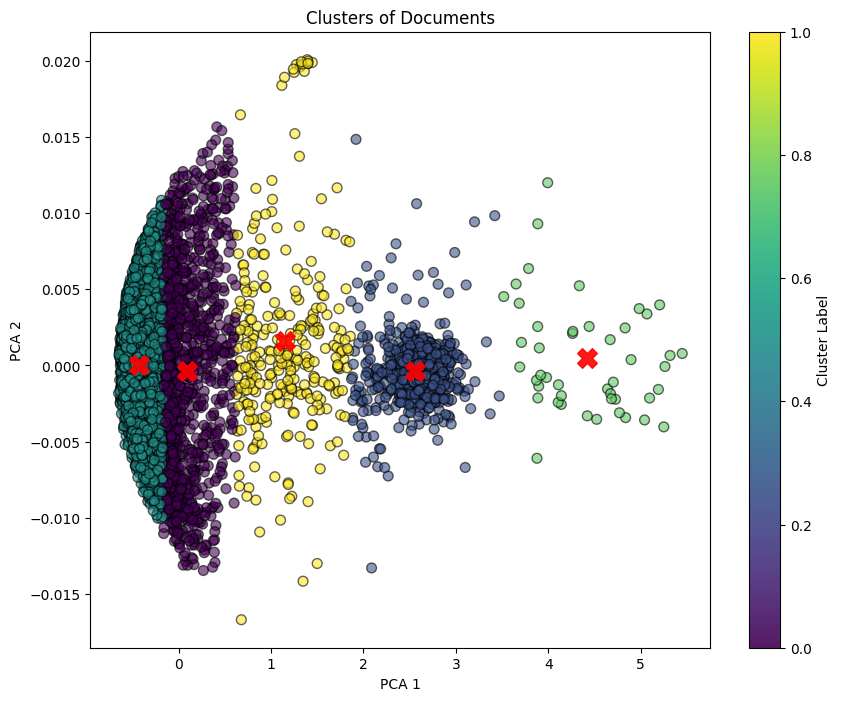

In [36]:
import matplotlib.pyplot as plt

# Assuming `X_pca` is your PCA-reduced data and `kmeans.labels_` are your cluster labels

# Scatter plot of the first two PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

# Plot centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X')

plt.title('Clusters of Documents')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster Label')

plt.show()


## Wrapper class for Lbl2Vec for use with SKLearn Hyperparameter Tuning

In [129]:
# def wrap_Lbl2Vec(model):
class Lbl2VecWrapper:
    def __init__(self, keywords, train_docs):
        self.lbl2vec = Lbl2Vec(keywords, train_docs)

    def fit(self, data):
        return self.lbl2vec.predict_new_docs(data)
    
    def get_params(self, deep=None):
        return self.lbl2vec.get_params(deep)
        
    # return Lbl2VecWrapper

## Score function:

In [148]:
def evaluate_lbl2_vec_silhouette(model, x, y=None):

    sim_scores = model.predict_new_docs(x)

    features = [f'label_{i}' for i in range(11)] 
    X = sim_scores[features]

    # Apply PCA to reduce dimensions
    pca = PCA(n_components=2)  # Adjust `n_components` as needed
    X_pca = pca.fit_transform(X)

    kmeans = KMeans(n_clusters=11, random_state=42)
    kmeans.fit(X_pca)

    silhouette_avg = silhouette_score(X_pca, kmeans.labels_)

    return silhouette_avg


## Hyperparameter Tuning:
Hyperparameters to tune:
1. similarity threshold [0, 1]
2. window n > 0
3. epochs n > 0
4. negative n > 0
5. clean outliers boolean

In [131]:
import itertools

In [147]:
# Create param_grid

train_docs = all_descriptions['tagged_desc'][all_descriptions.data_type == 'train']
validate_docs = all_descriptions['tagged_desc'][all_descriptions.data_type == 'validate']

keywords_list = [list(category_keywords['keywords'])]
tagged_documents = [train_docs]
min_count = [1]
window = range(10, 20)
negative = range(3, 7)
similarity_threshold = np.arange(start=0.3, stop=0.8, step=0.05, dtype=np.float32)
# clean_outliers = [True, False]

param_grid = [
    {
        'keywords_list': item[0],
        'tagged_documents': item[1],
        'min_count': item[2],
        'window': item[3],
        # 'negative': item[4],
        'similarity_threshold': item[4],
        # 'clean_outliers': item[5]
    }
    for item in itertools.product(*[
        keywords_list,
        tagged_documents,
        min_count,
        window,
        # negative,
        similarity_threshold,
        # clean_outliers
    ])
]

len(param_grid)

100